# Train a model to learn Font names from text in an image
### Using Supervised Learning with Tensorflow

Data is received in a pickle that contains:
- List of font names
- Images: 50px x 50px white on black images (in gray colorspace -> 1 color channel)
- Labels: 0..(nb_fonts-1)  
---
Francois Robert

In [1]:
# Load packages
from IPython.display import display, Image
import imageio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import os
from six.moves import cPickle as pickle

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from pathlib import Path

import tensorflow as tf

from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, BatchNormalization, Activation, Input, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing import image

In [3]:
from platform import python_version

print(python_version())

3.8.5


In [4]:
import tensorflow as tf
print(tf.__version__)

2.3.1


In [5]:
seed = 12
np.random.seed(seed)

# Define environment variables

In [6]:
BASEDIR = ".."

# Input
PICKLE_DIR = os.path.join(BASEDIR, "pickles")
DATAFILE   = os.path.join(PICKLE_DIR, 'font.pickle')

# Output
MODEL_DIR  = os.path.join(BASEDIR, "saved_models")
model_name = os.path.join(MODEL_DIR, "font.model.01.h5") 

In [7]:
# Create Model directory
Path(MODEL_DIR).mkdir(parents=True, exist_ok=True)

## Load pickled data dictionary containing trained, validation datasets

In [8]:
with open(DATAFILE, 'rb') as file:
    data_dict = pickle.load(file)

In [9]:
# Show the actual font names in the dataaz
output_labels = data_dict['font_names']

print("Fonts")
for label, font_name in enumerate(output_labels):
    print(f"{label}: {font_name}")

Fonts
0: Aladin-Regular
1: AlexBrush-Regular
2: Allura-Regular
3: AmaticSC-Regular
4: AmericanTypewriter-Condensed
5: Bonbon-Regular
6: BowlbyOneSC-Regular
7: BradleyHandITCTT-Bold
8: BrushScriptMT
9: CarterOne
10: Chalkduster
11: Cookie-Regular
12: Copperplate
13: CourierNewPSMT
14: Damion
15: DancingScript-Bold
16: Didot
17: FredokaOne-Regular
18: Futura-CondensedMedium
19: GochiHand-Regular
20: GrandHotel-Regular
21: GreatVibes-Regular
22: Helvetica-Bold
23: HelveticaNeue
24: Impact
25: Luminari-Regular
26: MarkerFelt-Thin
27: Noteworthy-Light
28: Optima-Regular
29: Pacifico-Regular
30: RockSalt
31: Rockwell-Regular
32: Shojumaru-Regular
33: TimesNewRomanPSMT
34: Yesteryear-Regular


In [10]:
image_size  = 50     # Pixel width and height
pixel_depth = 255.0  # Number of levels per pixel

In [11]:
nb_fonts = len(output_labels)

X = data_dict['images']
y = data_dict['labels']

images_per_font = X.shape[0] / nb_fonts

# Construct training set and validation set
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=seed)

In [12]:
# Training set
train_X.shape, train_y.shape

((23240, 50, 50), (23240,))

In [13]:
# Validation set
val_X.shape, val_y.shape

((5810, 50, 50), (5810,))

In [14]:
images_per_font

830.0

In [15]:
# Reshape images to add the channel (height = 50px, width = 50px , channel = 1)
X_train = train_X.reshape(-1, image_size, image_size, 1)
X_val   = val_X.reshape(-1, image_size, image_size, 1)

## Let's see how the data looks like

In [16]:
def plot_sample(image, axs):
   
    axs.imshow(image.reshape(image_size, image_size), cmap="gray")

In [17]:
def display_images(X, Y):
    """ 
    This function shows images with their real labels
    Presentation is rows of 5 images
    """

    fig = plt.figure(figsize=(13, 20))
    fig.subplots_adjust(hspace=1.1,wspace=0.1,
                        left=0,right=1,bottom=0, top=1)
    nb_pictures = len(X)
    nb_per_row = 5
    nb_of_row  = (nb_pictures - 1) // nb_per_row + 1    

    for i in range(nb_pictures):
        ax = fig.add_subplot(nb_of_row, nb_per_row, i+1, xticks=[], yticks=[]) 
        plot_sample(X[i].reshape((image_size, image_size)), ax)
        ax.set_title("{}".format(output_labels[Y[i]]))
    plt.show()

### Some Training data. Images with labels


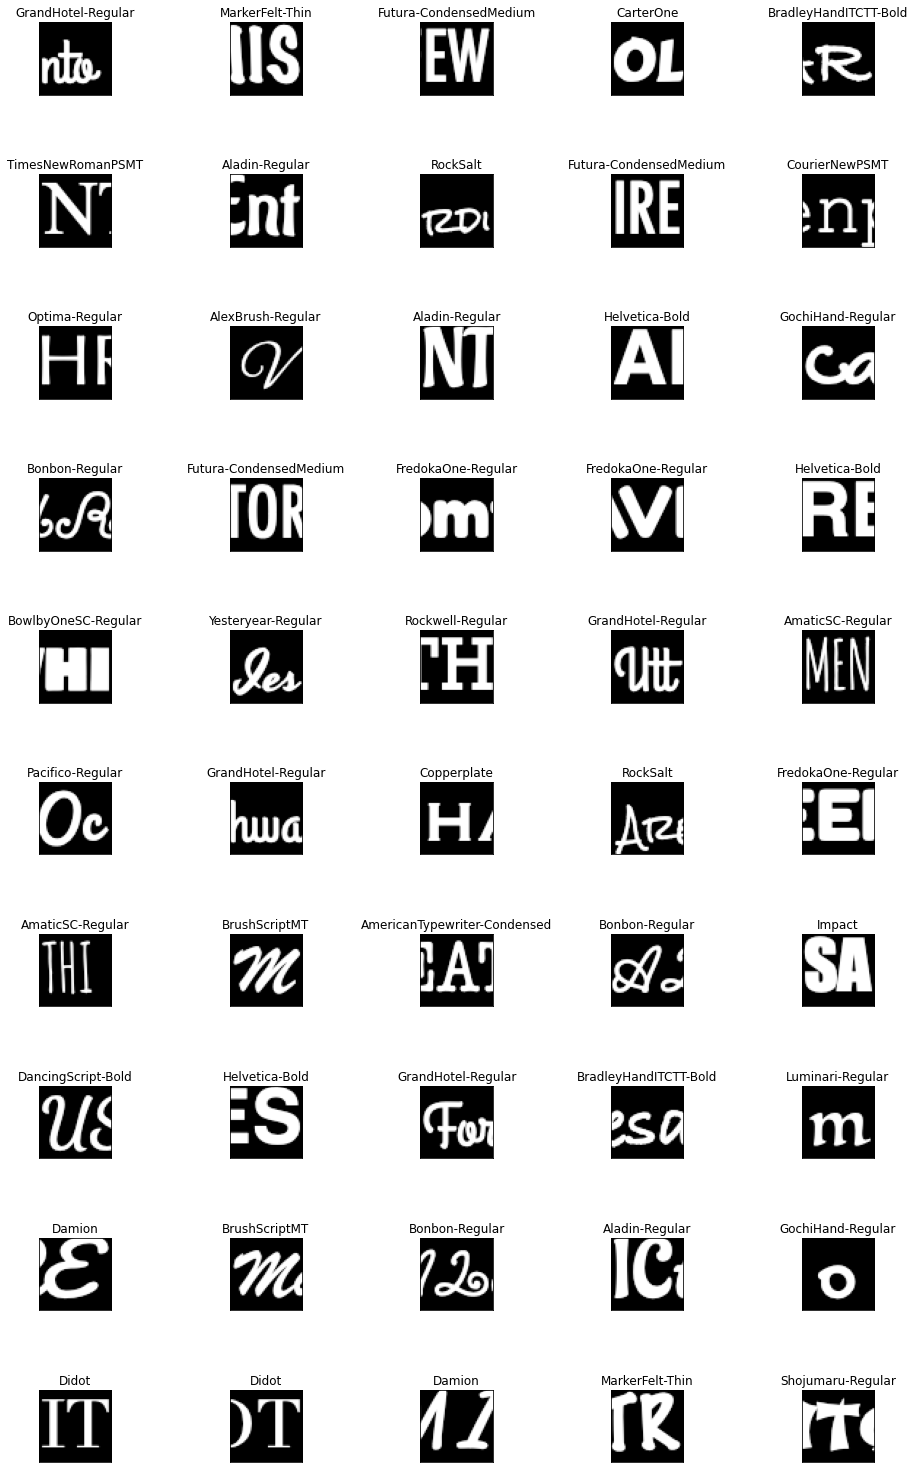

In [18]:
display_images(X_train[:50],train_y[:50])

### Some Validation data

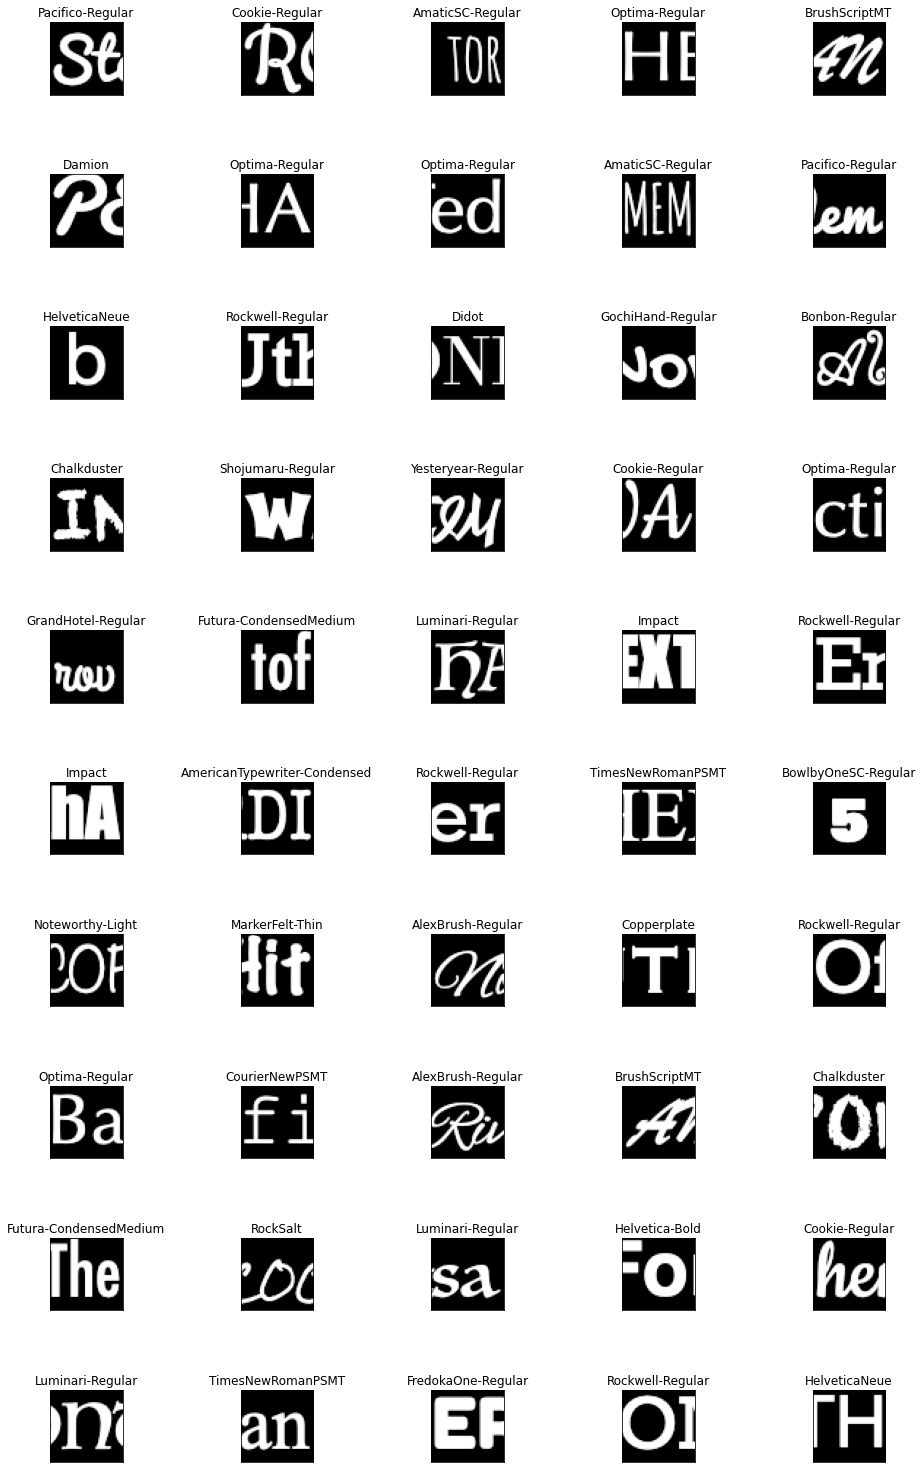

In [19]:
display_images(X_val[:50],val_y[:50])

In [20]:
# Let's see the label's shape before one hot encoding
train_y.shape,val_y.shape

((23240,), (5810,))

In [21]:
# Encode labels to one hot vectors 
Y_train = to_categorical(train_y, num_classes = nb_fonts)
Y_val   = to_categorical(val_y,   num_classes = nb_fonts)

In [22]:
X_train.shape,X_val.shape

((23240, 50, 50, 1), (5810, 50, 50, 1))

In [23]:
Y_train.shape,Y_val.shape

((23240, 35), (5810, 35))

In [24]:
tf.keras.backend.clear_session()

## Define the model

In [25]:
def get_model_cnn1():
    # Set the CNN model using Keras functional API
    input_img = Input(shape=(image_size,image_size,1))

    x = Conv2D(32, (5, 5), padding='same')(input_img)  # Conv2D 1
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(32, (5, 5), padding='same')(x)          # Conv2D 2
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (5, 5))(x)                          # Conv2D 3
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3))(x)                          # Conv2D 4
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.2)(x)

    x = Conv2D(128, (3, 3))(x)                         # Conv2D 5
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3))(x)                         # Conv2D 6
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    x = Flatten()(x)
    x = Dense(128)(x)  
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.4)(x)
    output = Dense(nb_fonts, activation = "softmax")(x)

    model = Model(inputs=input_img, outputs=output)
    
    return model

In [26]:
# select a model
model = get_model_cnn1()

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 50, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 50, 50, 32)        832       
_________________________________________________________________
batch_normalization (BatchNo (None, 50, 50, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 32)        25632     
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 50, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 50, 50, 32)       

## Compile the model

In [27]:
# We do data augmentation to prevent overfitting and adapt better.
datagen = ImageDataGenerator(
        featurewise_center=False,             # set input mean to 0 over the dataset
        samplewise_center=False,              # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,   # divide each input by its std
        zca_whitening=False,                  # apply ZCA whitening
        rotation_range=0,                     # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = [0.9, 1.11],             # Randomly zoom image 
        width_shift_range=0.05,               # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.05,              # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,                # randomly flip images
        vertical_flip=False)                  # randomly flip images

In [28]:
# Keras callback to the result of the best epoch in the model
# Intended to work with ModelCheckpoint callback.
class ShowBestEpochResult(tf.keras.callbacks.Callback):
    def __init__(self, on_param='val_loss', show_params=['val_loss', 'loss'], mode='min'):
        self.on_param    = on_param
        self.show_params = show_params
        self.mode        = mode

    def on_train_begin(self, logs=None):
        # The number of epoch at which the best value is found.
        self.best_epoch = 0

        # The best value found for the on_param.
        self.best = np.Inf
        if self.mode == 'max':
            self.best = np.NINF
            
        # The values on best epoch for each param in show_param.
        self.best_values = {}

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.on_param)
        save_as_best = (self.mode=='min' and current < self.best) or \
                       (self.mode=='max' and current > self.best)

        if save_as_best: 
            self.best = current
            for param in self.show_params:
                self.best_values[param] = logs.get(param)
            self.best_epoch = epoch

    def on_train_end(self, logs=None):
        print(f"BestEpochResult. Epoch: {self.best_epoch+1},", end=" ")

        for param in self.best_values:
            print(f"{param}: {self.best_values[param]:.5f},", end=" ")
        print(" ")

In [29]:
# Define the optimizer. Adam is generally my best bet.
optimizer = Adam(lr=0.0001, decay=0.0)

In [30]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [31]:
# Lower the learning rate if accuracy stops improving.
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=8, 
                                            verbose=1, 
                                            factor=0.8, 
                                            min_delta=1e-7,
                                            min_lr=1e-7)


## Train the model

In [32]:
# Fit the model with data Augmentation
# I like to start a few epoch with a small batch size because:
# - This basically makes the learning rate larger. https://openreview.net/pdf?id=B1Yy1BxCZ#:~:text=Increasing%20the%20batch%20size%20during%20training%20achieves%20similar%20results%20to,twice%20to%20illustrate%20the%20variance.
# - This covers to 0 to 80% of the accuracy curve, cleaning the graphs
epochs = 2 # Turn epochs to ...
batch_size = 32  
history = model.fit(datagen.flow(X_train, Y_train, batch_size=batch_size),
                              epochs=epochs, validation_data = (X_val, Y_val),
                              verbose=1, steps_per_epoch=X_train.shape[0] // batch_size)

Epoch 1/2
726/726 [==============================] - 10s 14ms/step - loss: 2.4618 - accuracy: 0.3239 - val_loss: 1.1947 - val_accuracy: 0.7826
Epoch 2/2
726/726 [==============================] - 10s 14ms/step - loss: 1.3577 - accuracy: 0.6385 - val_loss: 0.5861 - val_accuracy: 0.8929


In [33]:
# From now on, we will save the model with the best accuracy
checkpoint = ModelCheckpoint(model_name, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
       
best_epoch_results = ShowBestEpochResult(on_param='val_accuracy', 
                                         show_params=['val_accuracy', 'accuracy', 'val_loss', 'loss'], 
                                         mode='max')

callbacks_list = [learning_rate_reduction, checkpoint, best_epoch_results]

epochs = 120
batch_size = 128  
history = model.fit(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs=epochs, validation_data=(X_val, Y_val),
                              verbose=1, steps_per_epoch=X_train.shape[0] // batch_size,
                              callbacks=callbacks_list)

Epoch 1/120
181/181 [==============================] - ETA: 0s - loss: 0.9124 - accuracy: 0.7825
Epoch 00001: val_accuracy improved from -inf to 0.93236, saving model to ../saved_models/font.model.01.h5
181/181 [==============================] - 9s 48ms/step - loss: 0.9124 - accuracy: 0.7825 - val_loss: 0.4969 - val_accuracy: 0.9324
Epoch 2/120
181/181 [==============================] - ETA: 0s - loss: 0.7973 - accuracy: 0.8136
Epoch 00002: val_accuracy improved from 0.93236 to 0.94664, saving model to ../saved_models/font.model.01.h5
181/181 [==============================] - 8s 46ms/step - loss: 0.7973 - accuracy: 0.8136 - val_loss: 0.4311 - val_accuracy: 0.9466
Epoch 3/120
181/181 [==============================] - ETA: 0s - loss: 0.7027 - accuracy: 0.8437
Epoch 00003: val_accuracy improved from 0.94664 to 0.95628, saving model to ../saved_models/font.model.01.h5
181/181 [==============================] - 8s 46ms/step - loss: 0.7027 - accuracy: 0.8437 - val_loss: 0.3569 - val_accura

Epoch 28/120
181/181 [==============================] - ETA: 0s - loss: 0.0834 - accuracy: 0.9828
Epoch 00028: val_accuracy did not improve from 0.98692
181/181 [==============================] - 8s 46ms/step - loss: 0.0834 - accuracy: 0.9828 - val_loss: 0.0773 - val_accuracy: 0.9807
Epoch 29/120
181/181 [==============================] - ETA: 0s - loss: 0.0798 - accuracy: 0.9836
Epoch 00029: val_accuracy did not improve from 0.98692
181/181 [==============================] - 8s 46ms/step - loss: 0.0798 - accuracy: 0.9836 - val_loss: 0.1203 - val_accuracy: 0.9670
Epoch 30/120
181/181 [==============================] - ETA: 0s - loss: 0.0758 - accuracy: 0.9837
Epoch 00030: val_accuracy did not improve from 0.98692
181/181 [==============================] - 8s 46ms/step - loss: 0.0758 - accuracy: 0.9837 - val_loss: 0.0633 - val_accuracy: 0.9857
Epoch 31/120
181/181 [==============================] - ETA: 0s - loss: 0.0730 - accuracy: 0.9848
Epoch 00031: val_accuracy did not improve from 

Epoch 56/120
181/181 [==============================] - ETA: 0s - loss: 0.0325 - accuracy: 0.9926
Epoch 00056: val_accuracy improved from 0.99036 to 0.99122, saving model to ../saved_models/font.model.01.h5
181/181 [==============================] - 8s 46ms/step - loss: 0.0325 - accuracy: 0.9926 - val_loss: 0.0374 - val_accuracy: 0.9912
Epoch 57/120
181/181 [==============================] - ETA: 0s - loss: 0.0305 - accuracy: 0.9932
Epoch 00057: val_accuracy did not improve from 0.99122
181/181 [==============================] - 8s 46ms/step - loss: 0.0305 - accuracy: 0.9932 - val_loss: 0.0350 - val_accuracy: 0.9909
Epoch 58/120
181/181 [==============================] - ETA: 0s - loss: 0.0316 - accuracy: 0.9923
Epoch 00058: val_accuracy did not improve from 0.99122
181/181 [==============================] - 8s 46ms/step - loss: 0.0316 - accuracy: 0.9923 - val_loss: 0.0583 - val_accuracy: 0.9849
Epoch 59/120
181/181 [==============================] - ETA: 0s - loss: 0.0280 - accuracy: 

Epoch 84/120
181/181 [==============================] - ETA: 0s - loss: 0.0185 - accuracy: 0.9951
Epoch 00084: val_accuracy did not improve from 0.99260
181/181 [==============================] - 8s 46ms/step - loss: 0.0185 - accuracy: 0.9951 - val_loss: 0.0721 - val_accuracy: 0.9795
Epoch 85/120
181/181 [==============================] - ETA: 0s - loss: 0.0167 - accuracy: 0.9961
Epoch 00085: val_accuracy did not improve from 0.99260
181/181 [==============================] - 8s 46ms/step - loss: 0.0167 - accuracy: 0.9961 - val_loss: 0.0809 - val_accuracy: 0.9775
Epoch 86/120
181/181 [==============================] - ETA: 0s - loss: 0.0162 - accuracy: 0.9964
Epoch 00086: val_accuracy did not improve from 0.99260
181/181 [==============================] - 8s 46ms/step - loss: 0.0162 - accuracy: 0.9964 - val_loss: 0.0452 - val_accuracy: 0.9885
Epoch 87/120
181/181 [==============================] - ETA: 0s - loss: 0.0158 - accuracy: 0.9966
Epoch 00087: ReduceLROnPlateau reducing learnin

Epoch 112/120
181/181 [==============================] - ETA: 0s - loss: 0.0108 - accuracy: 0.9977
Epoch 00112: val_accuracy did not improve from 0.99277
181/181 [==============================] - 8s 46ms/step - loss: 0.0108 - accuracy: 0.9977 - val_loss: 0.0389 - val_accuracy: 0.9909
Epoch 113/120
181/181 [==============================] - ETA: 0s - loss: 0.0107 - accuracy: 0.9978
Epoch 00113: val_accuracy did not improve from 0.99277
181/181 [==============================] - 8s 46ms/step - loss: 0.0107 - accuracy: 0.9978 - val_loss: 0.0377 - val_accuracy: 0.9912
Epoch 114/120
181/181 [==============================] - ETA: 0s - loss: 0.0105 - accuracy: 0.9977
Epoch 00114: val_accuracy did not improve from 0.99277
181/181 [==============================] - 8s 46ms/step - loss: 0.0105 - accuracy: 0.9977 - val_loss: 0.0406 - val_accuracy: 0.9912
Epoch 115/120
181/181 [==============================] - ETA: 0s - loss: 0.0105 - accuracy: 0.9976
Epoch 00115: val_accuracy did not improve f

## Plot the loss and accuracy curves for training and validation.

In [34]:
def plot_loss(hist, name, plt):
    loss = hist['loss']
    val_loss = hist['val_loss']
        
    plt.plot(loss,"--",linewidth=3,label="train:"+name)
    plt.plot(val_loss,linewidth=3,label="val:"+name)

In [35]:
def plot_accuracy(hist, name, plt):
    loss     = hist['accuracy']
    val_loss = hist['val_accuracy']
        
    plt.plot(loss,"--",linewidth=3,label="train:"+name)
    plt.plot(val_loss,linewidth=3,label="val:"+name)

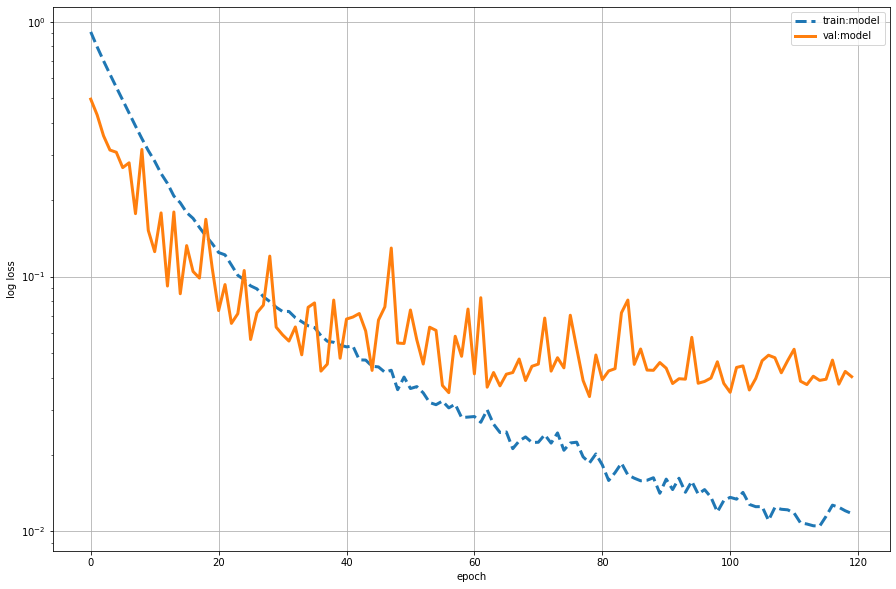

In [36]:
plt.figure(figsize=(15, 10))
plot_loss(history.history, "model", plt)
plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("log loss")
plt.show()

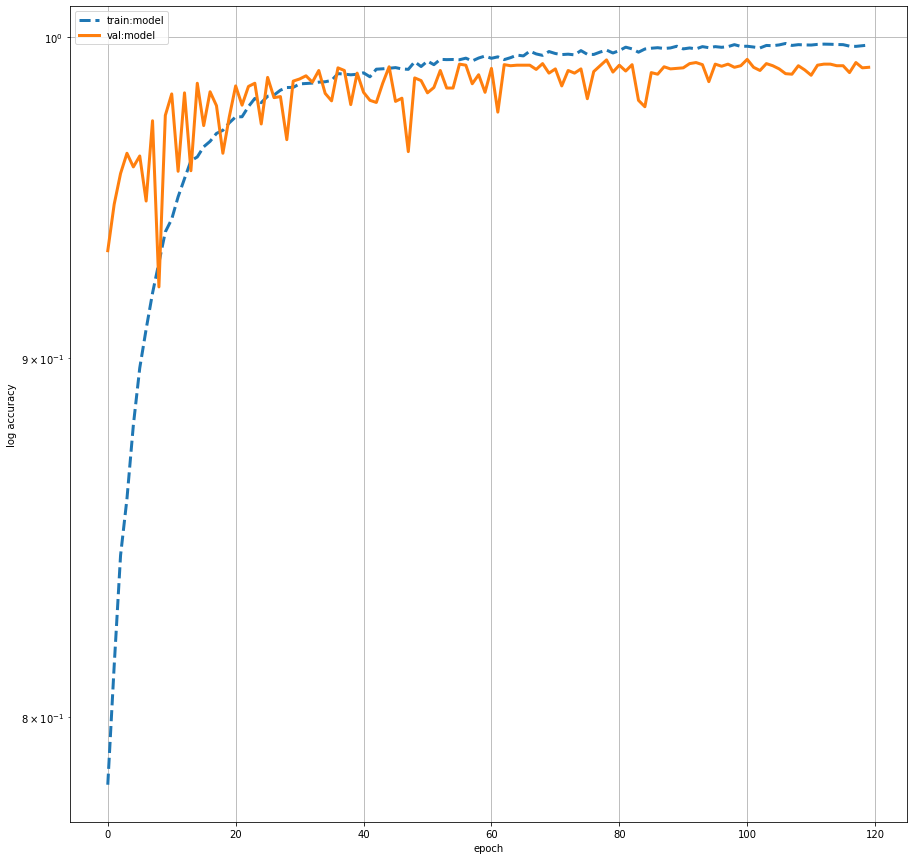

In [37]:
plt.figure(figsize=(15, 15))
plot_accuracy(history.history, "model", plt)
plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("log accuracy")
plt.show()

## Delete the existing model + Load best model

In [40]:
# deletes the existing model
del model

# Load last saved model, ie the one with the best accuracy
model = load_model(model_name)

## Look at confusion matrix 

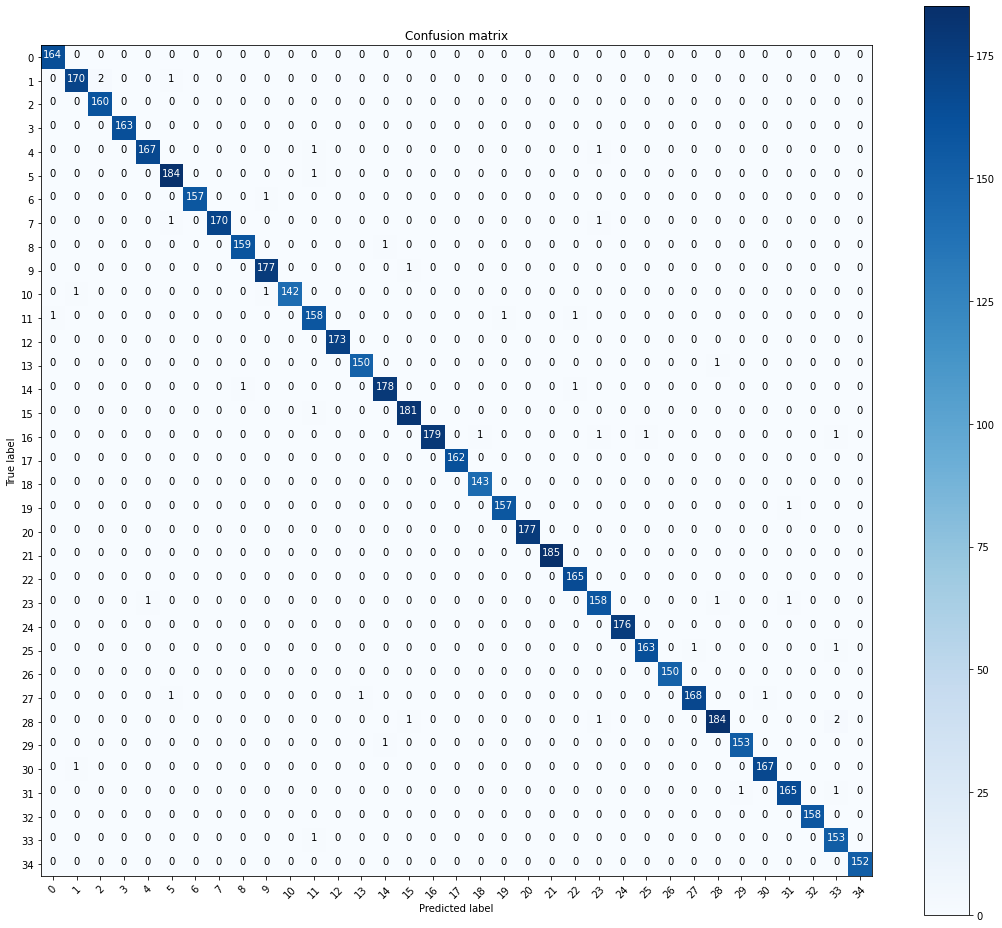

In [41]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(15, 13))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 

# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(nb_fonts)) 

In [42]:
# We see that the "biggest" confusion exists between: 
# - 1: AlexBrush-Regular
# - 2: Allura-Regular

In [43]:
print("Y_pred shape: ", Y_pred.shape)                 # Prediction for each image in the validaset set
print("Y_pred_classes shape: ", Y_pred_classes.shape) # Index of the font prediction for each image in the val. set
print("Y_true shape: ", Y_true.shape)                 # Index of the actual font for each image in the val. set
print("confusion_mtx shape: ", confusion_mtx.shape)   # Values in the confusion matrix shown above

Y_pred shape:  (5810, 35)
Y_pred_classes shape:  (5810,)
Y_true shape:  (5810,)
confusion_mtx shape:  (35, 35)


In [44]:
Y_pred_classes[0:12]

array([29, 11,  3, 28,  8, 14, 28, 28,  3, 29, 23, 31])

In [45]:
X_val.shape

(5810, 50, 50, 1)

## Analyze the errors

In [46]:
# Display some error results 

# Errors are difference between predicted labels and true labels. Error[i] is True if this is an error
errors = (Y_pred_classes - Y_true != 0)

# Y_pred_errors: List of Images in the validation set where prediction was bad
X_val_errors = X_val[errors]

# Y_true_errors: Index of the actual font in the validation set where prediction was bad
Y_true_errors = Y_true[errors]

# Y_pred_classes_errors: The list of indexes for font predictions that were bad
Y_pred_classes_errors = Y_pred_classes[errors]

# Y_pred_errors: Prediction for each font in the validation set where prediction was bad
Y_pred_errors = Y_pred[errors]

In [47]:
def display_errors(errors_index, img_errors, pred_errors, obs_errors):
    """ This function shows images with their predicted and real labels"""

    fig = plt.figure(figsize=(13, 15))
    fig.subplots_adjust(hspace=0.13, wspace=0.2, left=0, right=1, bottom=0, top=1)
    nb_pictures = len(errors_index)
    nb_per_row = 5
    nb_of_row  = (nb_pictures - 1) // nb_per_row + 1  
    
    for i in range(nb_pictures):
        ax = fig.add_subplot(nb_of_row , nb_per_row, i+1, xticks=[], yticks=[]) 
        error = errors_index[i]
        plot_sample((img_errors[error]).reshape((image_size,image_size)), ax)
        ax.set_title("Pred: {}\nTrue : {}".format(output_labels[pred_errors[error]], output_labels[obs_errors[error]]))
    plt.show() 

### Show the biggest errors

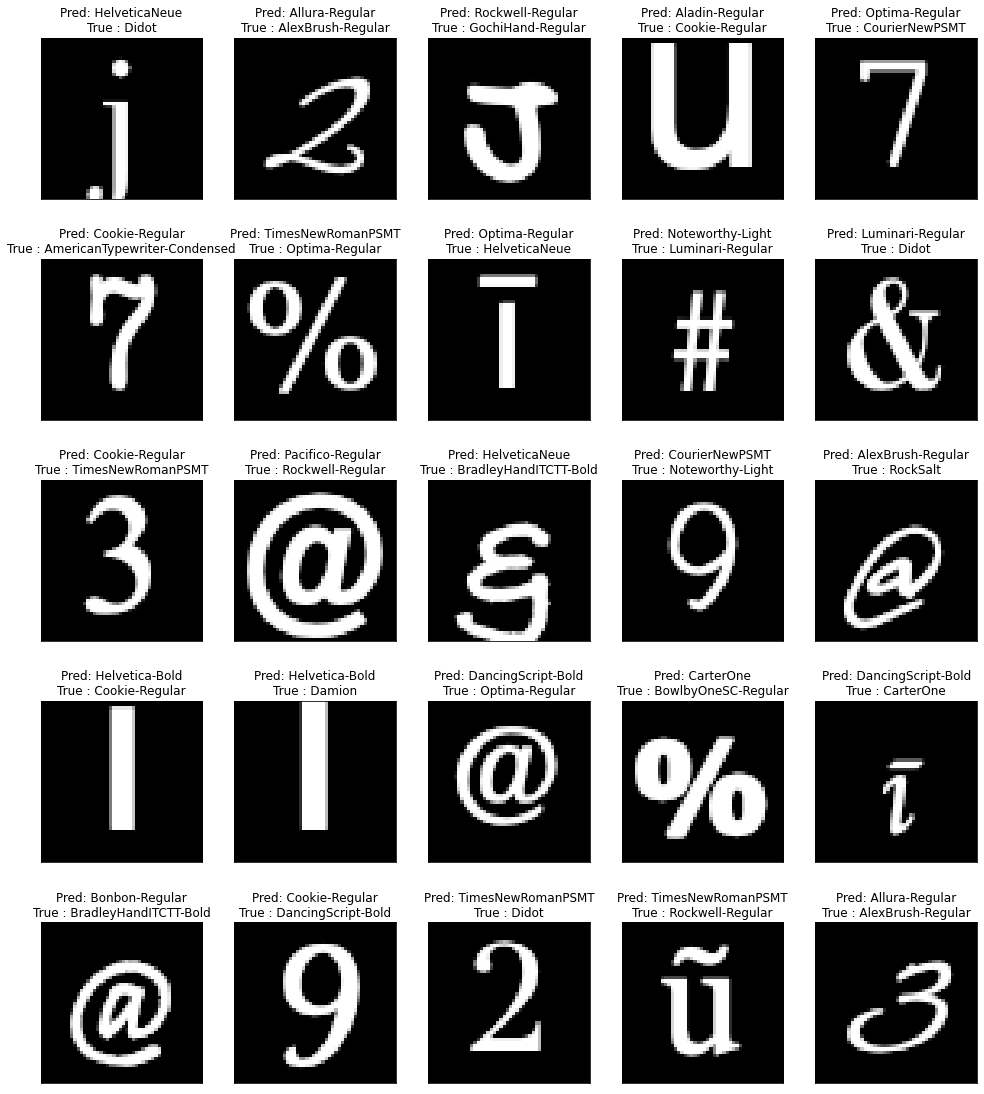

In [48]:
# Probabilities of the wrong predicted numbers. Prob for the bad choice
Y_pred_errors_prob = np.max(Y_pred_errors, axis = 1)

# Predicted probabilities of the true values in the error set. Prob for the good choice
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_delta_errors = np.argsort(delta_pred_true_errors)

# Top errors 
most_important_errors = sorted_delta_errors[-25:]

# Show the top errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [49]:
# We see that most errors are for individual characters for similar fonts. That's expected. Good.
#
# Note that some parts of images might be in the training dataset and also in the validation dataset. This
# would falsely improve the accuracy.

## Show Saliency maps - Which pixels were used for predictions

In [50]:
def saliency_map(input_image, model, label, image_size, num_classes):
    '''
    Generates the saliency map of a given gray scale image.

    Args:
        image -- picture that the model will classify
        model (keras Model) -- classifier
        label (int) -- ground truth label of the image
        image_size (int)  -- Image size in pixels
        num_classes (int) -- number of classes for label
    '''

    input_image = input_image.reshape(image_size, image_size)
    
    # Add an additional dimension (for the batch)
    image = np.expand_dims(input_image, axis=0)

    # Define the expected output array by one-hot encoding the label
    # The length of the array is equal to the number of classes
    expected_output = tf.one_hot([label] * image.shape[0], num_classes)

    
    with tf.GradientTape() as tape:
        # cast image to float
        inputs = tf.cast(image, tf.float32)

        # watch the input pixels
        tape.watch(inputs)

        # generate the predictions
        predictions = model(inputs)

        # Calculate the loss
        loss = tf.keras.losses.categorical_crossentropy(expected_output, predictions)

    # get the gradients of the loss with respect to the model's input image
    gradients = tape.gradient(loss, inputs)
    
    # generate the grayscale tensor
    grayscale_tensor = tf.abs(gradients[0])

    # The max value in the grayscale tensor will be pushed to 1.0
    # The min value will be pushed to 0.
    normalized_tensor = (grayscale_tensor - tf.reduce_min(grayscale_tensor)) / \
         (tf.reduce_max(grayscale_tensor) - tf.reduce_min(grayscale_tensor))
    
    # Mix the saliency map with the original image
    mixed_image = input_image * 0.5 + normalized_tensor * 0.5

    return mixed_image.numpy()

In [51]:
def display_images_with_saliency_map(X, Y):
    """ This function shows Saliency maps for 25 images with their real labels"""

    fig = plt.figure(figsize=(13, 13))
    fig.subplots_adjust(hspace=0.1, wspace=0.2, left=0, right=1, bottom=0, top=1)
    nb_pictures = 25
    m = 0
    
    for i in range(nb_pictures):
        image_with_saliency = saliency_map(X[i], model, Y[i], image_size, nb_fonts)
        
        if np.isnan(image_with_saliency[0,0]):
            # TODO Investigate when this condition occurs exactly
            continue
        
        ax = fig.add_subplot(nb_pictures//5 , 5, m+1, xticks=[], yticks=[]) 
        plot_sample(image_with_saliency.reshape((image_size, image_size)), ax)
        ax.set_title("{}".format(output_labels[Y[m]]))
        
        m +=1
    plt.show()

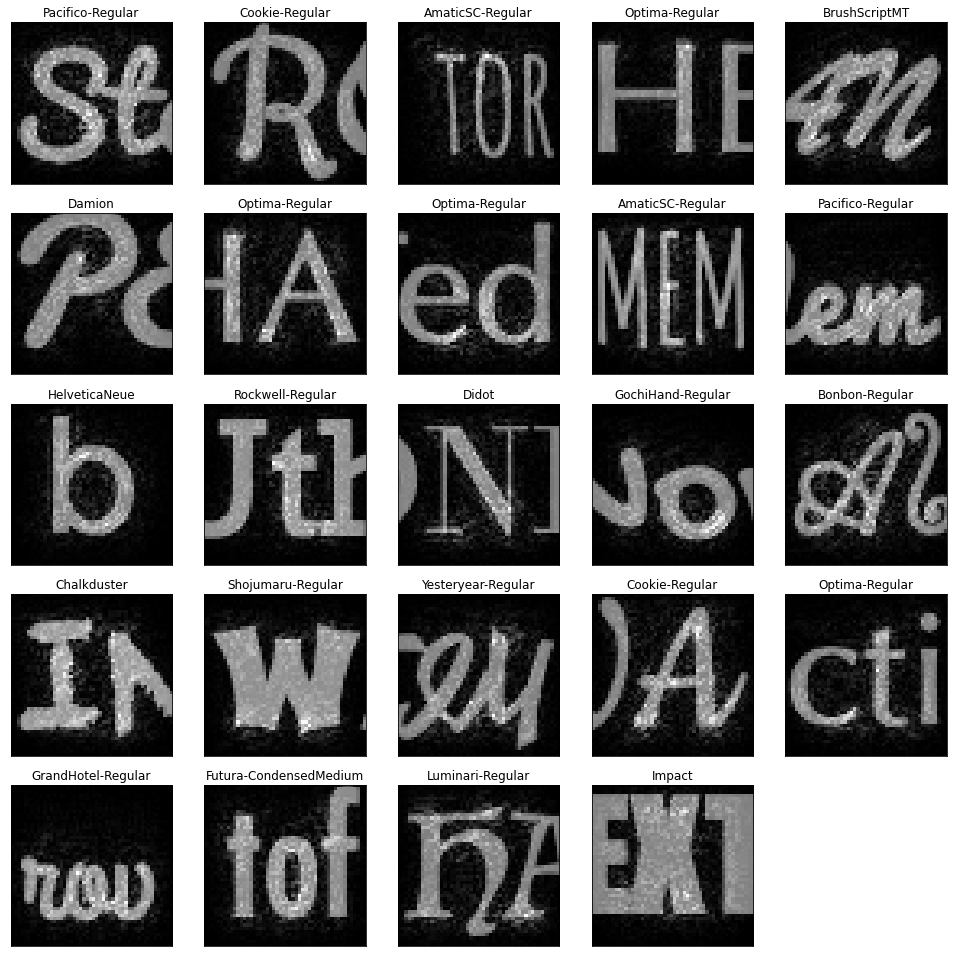

In [52]:
# Do a visualization of which pixels the model is focusing on when making its predictions
display_images_with_saliency_map(X_val[:25], val_y[:25])

In [53]:
# Debugging information
print("Validation shape: ", errors.shape)                 
print("X_val_errors shape: ", X_val_errors.shape)  
print("Y_true_errors shape: ", Y_true_errors.shape)                 
print("Y_pred_classes_errors shape: ", Y_pred_classes_errors.shape)                 
print("Y_pred_errors shape: ", Y_pred_errors.shape)

Validation shape:  (5810,)
X_val_errors shape:  (42, 50, 50, 1)
Y_true_errors shape:  (42,)
Y_pred_classes_errors shape:  (42,)
Y_pred_errors shape:  (42, 35)


In [54]:
# More Debugging information
print("Y_pred_errors_prob shape: ", Y_pred_errors_prob.shape)                 
print("true_prob_errors shape: ", true_prob_errors.shape)  
print("delta_pred_true_errors shape: ", delta_pred_true_errors.shape)                 
print("sorted_delta_errors shape: ", sorted_delta_errors.shape)                 
print("most_important_errors shape: ", most_important_errors.shape)

Y_pred_errors_prob shape:  (42,)
true_prob_errors shape:  (42,)
delta_pred_true_errors shape:  (42,)
sorted_delta_errors shape:  (42,)
most_important_errors shape:  (25,)


## Validation Accuracy

In [55]:
nb_errors = X_val_errors.shape[0]
nb_val_samples = Y_pred.shape[0]
accuracy = 1.0 - (nb_errors / nb_val_samples)

print("Validation Accuracy:", accuracy)
print(f"Number of errors: {nb_errors} from {nb_val_samples} predictions on validation set.")

Validation Accuracy: 0.9927710843373494
Number of errors: 42 from 5810 predictions on validation set.


## Conclusions

Interesting. I am **still amazed** as I would not know how to program this in a non "machine learning" way.

This is really a typical case where the model accuracy is **very close to what only a trained font expert could do**.